In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! kaggle datasets list
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!unzip gtsrb-german-traffic-sign.zip
!rm gtsrb-german-traffic-sign.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

In [ ]:
!rm -rf Meta
!rm -rf Train
!rm -rf Meta.csv
!rm -rf Train.csv

In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import torch

In [4]:
from PIL import Image

In [5]:
import torch.nn as nn
import torchvision.models as models
import torch

In [6]:
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import numpy as np

In [7]:
import torch.nn as nn
import torchvision.models as models
import torch

In [8]:
inst = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }


In [9]:
data_dir = "/content/"
train_path = 'Train'
test_path = 'Test'

NUM_CATEGORIES = len(os.listdir(train_path))

In [10]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
channels = 3

In [11]:
train = pd.read_csv(data_dir + '/Train.csv')
imgs = train["Path"]
classes = train["ClassId"]

In [12]:
train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [13]:
del train

In [14]:
#resize image to 224*224
def resize_image(image, size):
    """Resize an image to the given size."""
    return image.resize(size, Image.ANTIALIAS)


def resize_images(input_dir, output_dir, size):
    """Resize the images in 'input_dir' and save into 'output_dir'."""
    for idir in os.scandir(input_dir):
        #print(idir)
        if not idir.is_dir():
            continue
        if not os.path.exists(output_dir+'/'+idir.name):
            os.makedirs(output_dir+'/'+idir.name)    
        images = os.listdir(input_dir + '/' + idir.name)
        #print(len(images))
        n_images = len(images)
        for iimage, image in enumerate(images): 
          try:
            with open(os.path.join(input_dir + '/' + idir.name , image), 'r+b') as f:
                with Image.open(f) as img:
                  
                    img = resize_image(img, size)
                    img.save(os.path.join(output_dir + '/' + idir.name, image), img.format)
                      
          except(IOError, SyntaxError) as e:
            pass

In [15]:
!mkdir resized_images

In [16]:
IMAGE_PATH = "/content/Train"
RESIZE_IMAGE_PATH = "/content/resized_images"
#ANNOTATIONS_PATH = "/content/annotations"
image_size = [224, 224]

In [17]:
resize_images(IMAGE_PATH, RESIZE_IMAGE_PATH, image_size)

In [19]:
image_data = []
for img in imgs:
  image_data.append(img)

In [20]:
import random
random.shuffle(image_data)

In [21]:
embed_size = 1024

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
model = models.resnet18(pretrained=True)
in_features = model.fc.in_features
# # add more layers as required
# classifier = nn.Sequential(nn.Linear(n_inputs, ))
# model.fc = classifier
torch.nn.Sequential(*(list(model.children())[:-1]))

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [41]:
#@title ResNet
class Model(nn.Module):

    def __init__(self, embed_size):
        super(Model, self).__init__()
        
        model = models.resnet152(pretrained=True)
        in_features = model.fc.in_features
        # # add more layers as required
        classifier = nn.Sequential(nn.Linear(in_features, embed_size))
        model.fc = classifier
        torch.nn.Sequential(*(list(model.children())[:-1]))
        self.model = model                              # loaded model without last fc layer
        # self.fc1 = nn.Linear(in_features, embed_size)    # feature vector of image
        self.fc2 = nn.Linear(embed_size, 256)
        self.fc3 = nn.Linear(256, NUM_CATEGORIES)
        self.tanh = nn.Tanh()

    def forward(self, image):
        with torch.no_grad():
            img_feature = self.model(image)                  # [batch_size, vgg16(19)_fc=4096]
        # out = self.fc1(img_feature)                   # [batch_size, embed_size]
        # out = self.fc2(self.tanh(out))
        out = self.fc2(img_feature)                   # [batch_size, embed_size]

        out = self.fc3(out)

        # l2_norm = img_feature.norm(p=2, dim=1, keepdim=True).detach()
        # img_feature = img_feature.div(l2_norm)               # l2-normalized feature vector
        return out

In [ ]:
#@title VGG19
class Model(nn.Module):

    def __init__(self, embed_size):
        super(Model, self).__init__()
        model = models.vgg19(pretrained=True)
        in_features = model.classifier[-1].in_features  # input size of feature vector
        model.classifier = nn.Sequential(
            *list(model.classifier.children())[:-1])    # remove last fc layer
        self.model = model                              # loaded model without last fc layer
        self.fc1 = nn.Linear(in_features, embed_size)    # feature vector of image
        self.fc2 = nn.Linear(embed_size, 256)
        self.fc3 = nn.Linear(256, NUM_CATEGORIES)
        self.tanh = nn.Tanh()

    def forward(self, image):
        with torch.no_grad():
            img_feature = self.model(image)                  # [batch_size, vgg16(19)_fc=4096]
        out = self.fc1(img_feature)                   # [batch_size, embed_size]
        out = self.fc2(self.tanh(out))
        out = self.fc3(self.tanh(out))

        # l2_norm = img_feature.norm(p=2, dim=1, keepdim=True).detach()
        # img_feature = img_feature.div(l2_norm)               # l2-normalized feature vector
        return out

In [42]:
model = Model(embed_size).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [44]:
learning_rate = 0.001
step_size = 10
gamma = 0.1
num_epochs = 10
num_workers = 8
save_step = 1
num_data = len(image_data)

In [45]:
!mkdir model_dir

mkdir: cannot create directory ‘model_dir’: File exists


In [39]:
model_dir = "/content/model_dir"

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.485, 0.456, 0.406),
                                                        (0.229, 0.224, 0.225))])
        

for epoch in range(num_epochs):
  correct = 0
  scheduler.step()
  model.train()
  
  for i in range(num_data):
    
    img = Image.open('resized_images/' + image_data[i][6:]).convert('RGB')
    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    x = image_data[i][6:8]
    if x[-1] == "/":
      x = x[0]
    label = [0]
    label[0] = float(x)
    label = torch.LongTensor(label)
    # label = label.unsqueeze(0)
    label = label.to(device)
    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
      output = model(img)
      _, pred = torch.max(output, 1)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()

    correct += torch.stack([label == pred]).sum()

  print("Accuracy: ", correct/num_data, "Epoch", epoch)
  torch.save({'state_dict': model.state_dict()},
                os.path.join(model_dir, 'model.ckpt'))

/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-46-5400117e9921>:27: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.LongTensor(label)


Accuracy:  tensor(0.1814, device='cuda:0') Epoch 0
Accuracy:  tensor(0.3132, device='cuda:0') Epoch 1
Accuracy:  tensor(0.3825, device='cuda:0') Epoch 2
Accuracy:  tensor(0.4255, device='cuda:0') Epoch 3
Accuracy:  tensor(0.4561, device='cuda:0') Epoch 4
Accuracy:  tensor(0.4821, device='cuda:0') Epoch 5


In [ ]:
def road_sign_detection(sign_path, size):
  with open(sign_path, 'r+b') as f:
    with Image.open(f) as img:
      img = resize_image(img, size)
  
  img.show()
  img = transform(img)
  img = img.unsqueeze(0)
  img = img.to(device)
  output = model(img)
  _, pred = torch.max(output, 1)
  print(inst[pred.item()])

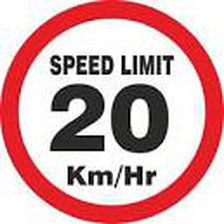

Speed limit (50km/h)


In [ ]:
road_sign_detection("/content/download.jpg", image_size)

Test

In [ ]:
N = len(os.listdir(test_path))

In [ ]:
test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"]
classes = test["ClassId"]

In [ ]:
IMAGE_PATH = "/content/Test"
RESIZE_IMAGE_PATH = "/content/resized_images"
#ANNOTATIONS_PATH = "/content/annotations"
image_size = [224, 224]

In [ ]:
#resize image to 224*224
def resize_image(image, size):
    """Resize an image to the given size."""
    return image.resize(size, Image.ANTIALIAS)


def resize_images(input_dir, output_dir, size):
    """Resize the images in 'input_dir' and save into 'output_dir'.""" 
    images = os.listdir(input_dir)
    #print(len(images))
    n_images = len(images)
    for iimage, image in enumerate(images): 
      try:
        with open(os.path.join(input_dir + '/', image), 'r+b') as f:
            with Image.open(f) as img:
              
                img = resize_image(img, size)
                img.save(os.path.join(output_dir + '/', image), img.format)
                  
      except(IOError, SyntaxError) as e:
        pass

In [ ]:
!mkdir resized_images

In [ ]:
resize_images(IMAGE_PATH, RESIZE_IMAGE_PATH, image_size)

In [ ]:
weights = torch.load("/content/model.ckpt")
model.load_state_dict(weights["state_dict"])

In [ ]:
classes[0]

16

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.485, 0.456, 0.406),
                                                        (0.229, 0.224, 0.225))])

for i in range(N):
    
    img = Image.open('resized_images/' + imgs[i][5:]).convert('RGB')
    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    label = classes[i]
    label = torch.LongTensor(label)

    output = model(img)
    _, pred = torch.max(output, 1)
    correct += torch.stack([label == pred]).sum()